# Final Semester Project - DEEP Reinforcements Learning

Student 1: Raz Atiya
Student 2: Nimrod Boazi

## Pre-Requisit

## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gymnasium
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre
!pip install minigrid
!wget -q https://www.dropbox.com/scl/fi/jhkb2y3jw8wgin9e26ooc/MiniGrid-MultiRoom-N6-v0_vid.mp4?rlkey=qtkrmmbk9aiote5z7w4bx6ixi&st=zbr4gk21&dl=1 -O content/MiniGrid-MultiRoom-N6-v0_vid.mp4


## Imports

In [ ]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
from torch.distributions.categorical import Categorical

In [ ]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"

## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(img, title="Image"):
    """
    Displays an image, automatically handling (56, 56, 3) and (3, 56, 56) formats.

    Args:
        img (numpy.ndarray): Image in shape (56, 56, 3) or (3, 56, 56).
        title (str): Title of the image.
    """
    if img.shape == (3, 56, 56):  # Convert (C, H, W) -> (H, W, C) for display
        img = np.transpose(img, (1, 2, 0))
    elif img.shape != (56, 56, 3):
        raise ValueError(f"Unexpected image shape: {img.shape}. Expected (56, 56, 3) or (3, 56, 56).")

    plt.figure(figsize=(3, 3))
    plt.imshow(img.astype(np.uint8))  # Ensure correct display format
    plt.title(title)
    plt.axis("off")
    plt.show()


## Validate Functions

In [ ]:
def create_video_DQN(agent, file_name):
    video_filename = f"/content/{file_name}.mp4"
    with imageio.get_writer(video_filename, fps=10) as video:

      double_with_stacking_rewards = []
      double_with_stacking_steps_array = []

      early_termination_count = 0

      max_steps = 125
      for i in range(1):
          done = False
          raw_observation, _ = env.reset()
          observation = preprocess_frame_stack(raw_observation, raw_observation, raw_observation, raw_observation)

          # Decalare Queues
          state_queue = deque(maxlen=120)
          action_queue = deque(maxlen=120)
          pre_process_state_queue = deque(maxlen=4)

          #
          state_queue.append(raw_observation)

          for j in range(4):
            pre_process_state_queue.append(raw_observation)

          total_reward = 0
          steps = 0
          while steps <= max_steps:
              steps += 1
              action = agent.choose_best_action(observation)
              #
              action_queue.append(action)
              raw_observation_, reward, done, truncated  , _ = env.step(action)

              #
              state_queue.append(raw_observation_)
              pre_process_state_queue.append(raw_observation_)
              #
              reward = reward_shaping(state_queue, done, truncated, action_queue)
              observation_ = preprocess_frame_stack(pre_process_state_queue[-4], pre_process_state_queue[-3], pre_process_state_queue[-2], pre_process_state_queue[-1])
              total_reward += reward

              observation = observation_

              video.append_data(env.render())

              if done or truncated:
                break

          double_with_stacking_rewards.append(reward)
          double_with_stacking_steps_array.append(steps)
      return double_with_stacking_rewards, double_with_stacking_steps_array

In [ ]:
def validate_agent_DQN(agent, num_of_runs, file_name):

    double_with_stacking_rewards = []
    double_with_stacking_steps_array = []


    early_termination_count = 0

    max_steps = 125
    for i in range(num_of_runs):
        done = False
        raw_observation, _ = env.reset()
        observation = preprocess_frame_stack(raw_observation, raw_observation, raw_observation, raw_observation)

        # Decalare Queues
        state_queue = deque(maxlen=120)
        action_queue = deque(maxlen=120)
        pre_process_state_queue = deque(maxlen=4)

        #
        state_queue.append(raw_observation)

        for j in range(4):
          pre_process_state_queue.append(raw_observation)

        total_reward = 0
        steps = 0
        while steps <= max_steps:
            steps += 1
            action = agent.choose_best_action(observation)
            #
            action_queue.append(action)
            raw_observation_, reward, done, truncated  , _ = env.step(action)

            #
            state_queue.append(raw_observation_)
            pre_process_state_queue.append(raw_observation_)
            #
            reward = reward_shaping(state_queue, done, truncated, action_queue)
            observation_ = preprocess_frame_stack(pre_process_state_queue[-4], pre_process_state_queue[-3], pre_process_state_queue[-2], pre_process_state_queue[-1])
            total_reward += reward

            observation = observation_

            if done or truncated:
              break

        double_with_stacking_rewards.append(reward)
        double_with_stacking_steps_array.append(steps)

    return double_with_stacking_rewards, double_with_stacking_steps_array



In [ ]:
def create_video_PPO(agent, file_name):
    video_filename = f"/content/{file_name}.mp4"
    with imageio.get_writer(video_filename, fps=10) as video:
          avg_score = 0
          n_steps = 0

          score_history = []
          steps_history = []
          for i in range(1):

              raw_observation, _ = env.reset()
              observation = preprocess_observation_check(raw_observation)
              done = False
              truncated = False
              score = 0
              ep_steps = 0

              # Decalare Queues
              state_queue = deque(maxlen=120)
              action_queue = deque(maxlen=120)
              state_queue.append(raw_observation)

              while not (done or truncated):  # Ensure the episode terminates properly
                  action, val = agent.choose_best_action(observation)
                  action_queue.append(action)
                  raw_observation_, reward, done, truncated, _ = env.step(action)

                  state_queue.append(raw_observation_)

                  observation_ = preprocess_observation_check(raw_observation_)

                  n_steps += 1
                  ep_steps += 1
                  score += reward  # Accumulate reward

                  observation = observation_

                  video.append_data(env.render())

          return score_history, steps_history

In [ ]:
def validate_agent_PPO(agent, num_of_runs, file_name):
    avg_score = 0
    n_steps = 0

    score_history = []
    steps_history = []
    for i in range(num_of_runs):

        raw_observation, _ = env.reset()
        observation = preprocess_observation_check(raw_observation)
        done = False
        truncated = False
        score = 0
        ep_steps = 0

        # Decalare Queues
        state_queue = deque(maxlen=120)
        action_queue = deque(maxlen=120)
        state_queue.append(raw_observation)

        while not (done or truncated):  # Ensure the episode terminates properly
            action, val = agent.choose_best_action(observation)
            action_queue.append(action)
            raw_observation_, reward, done, truncated, _ = env.step(action)

            state_queue.append(raw_observation_)

            observation_ = preprocess_observation_check(raw_observation_)

            n_steps += 1
            ep_steps += 1
            score += reward  # Accumulate reward

            observation = observation_

        score_history.append(score)
        steps_history.append(ep_steps)

    return score_history, steps_history

## Visualization Functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def moving_avg(data, window):
    """
    Computes the moving average of a given data array.

    Args:
        data (np.array): Input data.
        window (int): Window size for smoothing.

    Returns:
        np.array: Smoothed data using a moving average.
    """
    if len(data) < window:
        return np.full(len(data), np.mean(data))  # Handle small arrays
    return np.convolve(data, np.ones(window) / window, mode='valid')

def plot_training_rewards(rewards, window=100):
    """
    Plots the training progress showing episode rewards.

    Args:
        rewards (np.array): Rewards per episode (float values).
        window (int): Window size for moving average smoothing.
    """
    if not isinstance(rewards, (list, np.ndarray)):
        raise TypeError("'rewards' must be a list or NumPy array.")

    rewards = np.array(rewards, dtype=float)
    if len(rewards) == 0:
        raise ValueError("Error: 'rewards' must be a non-empty array.")

    window = min(len(rewards), window)  # Ensure window does not exceed array length
    avg_rewards = moving_avg(rewards, window)
    avg_x_rewards = np.arange(len(avg_rewards))

    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(np.arange(len(rewards)), rewards, label="Episode Reward", color="gray", alpha=0.3)
    plt.plot(avg_x_rewards, avg_rewards, label=f"Moving Avg ({window})", color="crimson", linewidth=2)
    plt.fill_between(avg_x_rewards, avg_rewards * 0.9, avg_rewards * 1.1, color="crimson", alpha=0.2)
    plt.title("Training Progress: Episode Rewards", fontsize=14, fontweight="bold")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

def plot_training_steps(steps, window=100):
    """
    Plots the training progress showing steps per episode.

    Args:
        steps (np.array): Steps taken per episode (float values).
        window (int): Window size for moving average smoothing.
    """
    if not isinstance(steps, (list, np.ndarray)):
        raise TypeError("'steps' must be a list or NumPy array.")

    steps = np.array(steps, dtype=float)
    if len(steps) == 0:
        raise ValueError("Error: 'steps' must be a non-empty array.")

    window = min(len(steps), window)  # Ensure window does not exceed array length
    avg_steps = moving_avg(steps, window)
    avg_x_steps = np.arange(len(avg_steps))

    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(np.arange(len(steps)), steps, label="Episode Steps", color="gray", alpha=0.3)
    plt.plot(avg_x_steps, avg_steps, label=f"Moving Avg ({window})", color="blue", linewidth=2)
    plt.fill_between(avg_x_steps, avg_steps * 0.97, avg_steps * 1.02, color="blue", alpha=0.2)
    plt.title("Training Progress: Steps per Episode", fontsize=14, fontweight="bold")
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


In [ ]:
def plot_comparison_rewards(rewards_algo1, rewards_algo2, algo1_name="Algorithm 1", algo2_name="Algorithm 2", window=100):
    """
    Plots a comparison of training rewards for two different algorithms.

    Args:
        rewards_algo1 (np.array): Rewards per episode for algorithm 1.
        rewards_algo2 (np.array): Rewards per episode for algorithm 2.
        algo1_name (str): Name of the first algorithm.
        algo2_name (str): Name of the second algorithm.
        window (int): Window size for moving average smoothing.
    """
    rewards_algo1 = np.array(rewards_algo1, dtype=float)
    rewards_algo2 = np.array(rewards_algo2, dtype=float)

    window = min(len(rewards_algo1), len(rewards_algo2), window)  # Ensure window does not exceed data length
    avg_rewards_1 = moving_avg(rewards_algo1, window)
    avg_rewards_2 = moving_avg(rewards_algo2, window)

    avg_x = np.arange(len(avg_rewards_1))

    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(np.arange(len(rewards_algo1)), rewards_algo1, label=f"{algo1_name} (Raw)", color="gray", alpha=0.3)
    plt.plot(avg_x, avg_rewards_1, label=f"{algo1_name} (Moving Avg)", color="crimson", linewidth=2)

    plt.plot(np.arange(len(rewards_algo2)), rewards_algo2, label=f"{algo2_name} (Raw)", color="gray", alpha=0.3)
    plt.plot(avg_x, avg_rewards_2, label=f"{algo2_name} (Moving Avg)", color="blue", linewidth=2)

    plt.title("Comparison of Training Rewards", fontsize=14, fontweight="bold")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

def plot_comparison_steps(steps_algo1, steps_algo2, algo1_name="Algorithm 1", algo2_name="Algorithm 2", window=100):
    """
    Plots a comparison of training steps for two different algorithms.

    Args:
        steps_algo1 (np.array): Steps per episode for algorithm 1.
        steps_algo2 (np.array): Steps per episode for algorithm 2.
        algo1_name (str): Name of the first algorithm.
        algo2_name (str): Name of the second algorithm.
        window (int): Window size for moving average smoothing.
    """
    steps_algo1 = np.array(steps_algo1, dtype=float)
    steps_algo2 = np.array(steps_algo2, dtype=float)

    window = min(len(steps_algo1), len(steps_algo2), window)  # Ensure window does not exceed data length
    avg_steps_1 = moving_avg(steps_algo1, window)
    avg_steps_2 = moving_avg(steps_algo2, window)

    avg_x = np.arange(len(avg_steps_1))

    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(np.arange(len(steps_algo1)), steps_algo1, label=f"{algo1_name} (Raw)", color="gray", alpha=0.3)
    plt.plot(avg_x, avg_steps_1, label=f"{algo1_name} (Moving Avg)", color="crimson", linewidth=2)

    plt.plot(np.arange(len(steps_algo2)), steps_algo2, label=f"{algo2_name} (Raw)", color="gray", alpha=0.3)
    plt.plot(avg_x, avg_steps_2, label=f"{algo2_name} (Moving Avg)", color="blue", linewidth=2)

    plt.title("Comparison of Steps per Episode", fontsize=14, fontweight="bold")
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


In [ ]:
def plot_training_losses(losses, window=25, use_log_scale=False):
    """
    Plots training loss progression.

    Args:
        losses (np.array): Loss values over training (very small float values).
        window (int): Window size for moving average smoothing.
        use_log_scale (bool): If True, uses log scale for better visualization.
    """
    if not isinstance(losses, (list, np.ndarray)):
        raise TypeError("'losses' must be a list or NumPy array.")

    losses = np.array(losses, dtype=float)

    if len(losses) == 0:
        raise ValueError("Error: 'losses' must be a non-empty array.")

    window = min(len(losses), window)  # Ensure window does not exceed array length

    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

    # Compute running average safely
    def moving_avg(data, window):
        if len(data) < window:
            return np.full(len(data), np.mean(data))  # Handle small arrays
        return np.convolve(data, np.ones(window) / window, mode='valid')

    avg_losses = moving_avg(losses, window)
    avg_x_losses = np.arange(len(avg_losses))

    # Plot Losses
    ax.plot(np.arange(len(losses)), losses, label="Loss per Update", color="gray", alpha=0.3)
    ax.plot(avg_x_losses, avg_losses, label=f"Moving Avg ({window})", color="blue", linewidth=2)
    ax.fill_between(avg_x_losses, avg_losses * 0.95, avg_losses * 1.05, color="blue", alpha=0.2)

    ax.set_title("Training Progress: Loss", fontsize=14, fontweight="bold")
    ax.set_xlabel("Training Step")
    ax.set_ylabel("Loss")

    # Apply log scale if needed
    if use_log_scale:
        ax.set_yscale("log")
        ax.set_title("Training Progress: Loss (Log Scale)", fontsize=14, fontweight="bold")

    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()



In [ ]:
# Re-defining the required functions before splitting them

import numpy as np
import matplotlib.pyplot as plt

def compute_success_rate(steps_array, window=100):
    """
    Computes the percentage of episodes ending in <120 steps every 100 episodes.

    Args:
        steps_array (np.array): Array of steps per episode (values between 0 and 120).
        window (int): Number of episodes per evaluation window (default=100).

    Returns:
        np.array: Success rate (%) per window.
        np.array: Corresponding episode numbers.
    """
    steps_array = np.array(steps_array, dtype=int)
    success_rates = []
    episode_indices = []

    for i in range(0, len(steps_array), window):
        sub_array = steps_array[i:i + window]
        early_termination_count = np.sum(sub_array < 120)
        success_rate = (early_termination_count / window) * 100
        success_rates.append(success_rate)
        episode_indices.append(i + window)

    return np.array(success_rates), np.array(episode_indices)

def compute_step_distribution(steps_array, window=100):
    """
    Computes the percentage of episodes falling into different step ranges in the last 'window' episodes.

    Args:
        steps_array (np.array or list): Array of steps per episode (values between 0 and 120).
        window (int): Number of episodes to analyze (default=100).

    Returns:
        list: Step range labels.
        np.array: Step range percentages.
        np.array: Step range counts (occurrences).
    """
    steps_array = np.array(steps_array, dtype=int)
    last_episodes = steps_array[max(0, len(steps_array) - window):]  # Ensure we don't index negatively

    # Define bins (inclusive of both bounds)
    bins = [(30, 39), (40, 49), (50, 59), (60, 69), (70, 79), (80, 89), (90, 99), (100, 109), (110, 119), (120, 120)]
    bin_labels = ["30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99", "100-109", "110-119", "120"]

    # Count occurrences in each bin
    bin_counts = [
        np.sum((last_episodes >= low) & (last_episodes <= high))  # Inclusive condition
        for low, high in bins
    ]

    total_count = len(last_episodes)  # Handle cases where fewer than 'window' episodes exist
    bin_percentages = (np.array(bin_counts) / total_count) * 100 if total_count > 0 else np.zeros(len(bin_counts))

    return bin_labels, bin_percentages, bin_counts

def plot_success_rate(steps_array, window=100):
    """
    Plots a line graph showing the percentage of episodes that ended in <120 steps every 100 episodes.

    Args:
        steps_array (np.array): Array of steps per episode (values between 0 and 120).
        window (int): Number of episodes per evaluation window (default=100).
    """
    success_rates, episode_indices = compute_success_rate(steps_array, window)

    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(episode_indices, success_rates, marker="o", linestyle="-", color="blue", linewidth=2)
    plt.title("Percentage of Episodes Ending in <120 Steps", fontsize=14, fontweight="bold")
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Success Rate (%)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

def plot_step_distribution(steps_array, window=100):
    """
    Plots a bar chart showing the percentage of steps in specific ranges for the last 100 episodes.

    Args:
        steps_array (np.array): Array of steps per episode (values between 0 and 120).
        window (int): Number of episodes to analyze (default=100).
    """
    bin_labels, bin_percentages, bin_counts = compute_step_distribution(steps_array, window)

    plt.figure(figsize=(12, 5), dpi=100)
    bars = plt.bar(bin_labels, bin_percentages, color="royalblue", alpha=0.7, edgecolor="black")

    # Add count labels above bars
    for bar, count in zip(bars, bin_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(count), ha="center", fontsize=12, fontweight="bold")

    plt.title(f"Step Distribution ({window} Episodes)", fontsize=14, fontweight="bold")
    plt.xlabel("Step Ranges", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_epsilon_decay(epsilon_values):
    """
    Plots the decay of epsilon over time.

    Args:
        epsilon_values (np.array or list): History of epsilon values over training episodes.
    """
    if not isinstance(epsilon_values, (list, np.ndarray)):
        raise TypeError("'epsilon_values' must be a list or NumPy array.")

    epsilon_values = np.array(epsilon_values, dtype=float)
    if len(epsilon_values) == 0:
        raise ValueError("Error: 'epsilon_values' must be a non-empty array.")

    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(np.arange(len(epsilon_values)), epsilon_values, color="blue", linewidth=2, label="Epsilon Decay")
    plt.title("Epsilon Decay Over Training", fontsize=14, fontweight="bold")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


In [ ]:
def plot_success_rate_comparison(steps_algo1, steps_algo2, algo1_name="Algorithm 1", algo2_name="Algorithm 2", window=100):
    """
    Plots a comparison of the percentage of episodes that ended in <120 steps every 100 episodes for two different algorithms.

    Args:
        steps_algo1 (np.array): Steps per episode for the first algorithm.
        steps_algo2 (np.array): Steps per episode for the second algorithm.
        algo1_name (str): Name of the first algorithm.
        algo2_name (str): Name of the second algorithm.
        window (int): Number of episodes per evaluation window (default=100).
    """
    # Compute success rates for both algorithms
    success_rates_1, episode_indices_1 = compute_success_rate(steps_algo1, window)
    success_rates_2, episode_indices_2 = compute_success_rate(steps_algo2, window)

    # Ensure both arrays have the same length for consistent plotting
    min_length = min(len(success_rates_1), len(success_rates_2))
    success_rates_1, success_rates_2 = success_rates_1[:min_length], success_rates_2[:min_length]
    episode_indices = episode_indices_1[:min_length]  # Use common episode indices

    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(episode_indices, success_rates_1, marker="o", linestyle="-", color="blue", linewidth=2, label=f"{algo1_name}")
    plt.plot(episode_indices, success_rates_2, marker="s", linestyle="--", color="red", linewidth=2, label=f"{algo2_name}")

    plt.title("Comparison of Success Rate (<120 Steps per Episode)", fontsize=14, fontweight="bold")
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Success Rate (%)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


In [ ]:
def plot_epsilon_comparison(epsilon_algo1, epsilon_algo2, algo1_name="Algorithm 1", algo2_name="Algorithm 2"):
    """
    Plots the epsilon decay for two different algorithms.

    Args:
        epsilon_algo1 (np.array or list): Epsilon values for the first algorithm.
        epsilon_algo2 (np.array or list): Epsilon values for the second algorithm.
        algo1_name (str): Name of the first algorithm.
        algo2_name (str): Name of the second algorithm.
    """
    if not isinstance(epsilon_algo1, (list, np.ndarray)) or not isinstance(epsilon_algo2, (list, np.ndarray)):
        raise TypeError("'epsilon_algo1' and 'epsilon_algo2' must be lists or NumPy arrays.")

    epsilon_algo1 = np.array(epsilon_algo1, dtype=float)
    epsilon_algo2 = np.array(epsilon_algo2, dtype=float)

    if len(epsilon_algo1) == 0 or len(epsilon_algo2) == 0:
        raise ValueError("Error: 'epsilon_algo1' and 'epsilon_algo2' must be non-empty arrays.")

    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(np.arange(len(epsilon_algo1)), epsilon_algo1, color="blue", linewidth=2, label=f"{algo1_name} Epsilon")
    plt.plot(np.arange(len(epsilon_algo2)), epsilon_algo2, color="red", linewidth=2, linestyle="--", label=f"{algo2_name} Epsilon")
    plt.title("Comparison of Epsilon Decay", fontsize=14, fontweight="bold")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


In [ ]:
# Re-import necessary libraries after execution state reset
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_comparison(losses_algo1, losses_algo2, algo1_name="Algorithm 1", algo2_name="Algorithm 2", window=25, use_log_scale=False):
    """
    Plots a comparison of training loss progression for two different algorithms.

    Args:
        losses_algo1 (np.array): Loss values for the first algorithm.
        losses_algo2 (np.array): Loss values for the second algorithm.
        algo1_name (str): Name of the first algorithm.
        algo2_name (str): Name of the second algorithm.
        window (int): Window size for moving average smoothing.
        use_log_scale (bool): If True, uses log scale for better visualization.
    """
    if not isinstance(losses_algo1, (list, np.ndarray)) or not isinstance(losses_algo2, (list, np.ndarray)):
        raise TypeError("'losses_algo1' and 'losses_algo2' must be lists or NumPy arrays.")

    losses_algo1 = np.array(losses_algo1, dtype=float)
    losses_algo2 = np.array(losses_algo2, dtype=float)

    if len(losses_algo1) == 0 or len(losses_algo2) == 0:
        raise ValueError("Error: 'losses_algo1' and 'losses_algo2' must be non-empty arrays.")

    # Ensure both arrays have the same length by trimming to the shortest length
    min_length = min(len(losses_algo1), len(losses_algo2))
    losses_algo1 = losses_algo1[:min_length]
    losses_algo2 = losses_algo2[:min_length]

    window = min(min_length, window)  # Ensure window does not exceed data length

    # Compute running averages
    def moving_avg(data, window):
        if len(data) < window:
            return np.full(len(data), np.mean(data))  # Handle small arrays
        return np.convolve(data, np.ones(window) / window, mode='valid')

    avg_losses_1 = moving_avg(losses_algo1, window)
    avg_losses_2 = moving_avg(losses_algo2, window)

    avg_x = np.arange(len(avg_losses_1))

    plt.figure(figsize=(12, 6), dpi=100)
    plt.plot(np.arange(len(losses_algo1)), losses_algo1, label=f"{algo1_name} (Raw)", color="gray", alpha=0.3)
    plt.plot(avg_x, avg_losses_1, label=f"{algo1_name} (Moving Avg)", color="blue", linewidth=2)

    plt.plot(np.arange(len(losses_algo2)), losses_algo2, label=f"{algo2_name} (Raw)", color="gray", alpha=0.3)
    plt.plot(avg_x, avg_losses_2, label=f"{algo2_name} (Moving Avg)", color="red", linewidth=2)

    plt.title("Comparison of Training Loss", fontsize=14, fontweight="bold")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")

    if use_log_scale:
        plt.yscale("log")
        plt.title("Comparison of Training Loss (Log Scale)", fontsize=14, fontweight="bold")

    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


## Project

In [ ]:
!mkdir models
!mkdir plots
!mkdir -p tiles
!wget -q "https://www.dropbox.com/scl/fi/mrbmkff4eneute9hm6x7p/yellow_tile_close.npy?rlkey=9nl2wi865pqr7nub8qteko4n3&st=mrkcj2br&dl=0" -O tiles/yellow_tiles_close.npy
!wget -q "https://www.dropbox.com/scl/fi/ohe2wby8906kyagqihl7i/tile_open.npy?rlkey=tcnixs088td3yg4pz7qryc6ml&st=l8z38edp&dl=0" -O tiles/yellow_tiles_open.npy

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘plots’: File exists


## Preprocess

By analyzing the environment, we realized that extracting the tile containing the **door** allows us to assign rewards based on the observation.

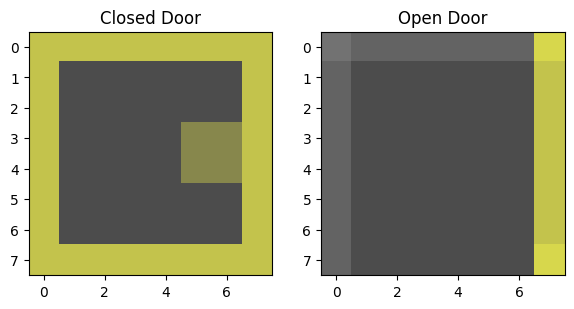

In [ ]:
tile_close = np.load('tiles/yellow_tiles_close.npy')
tile_open = np.load('tiles/yellow_tiles_open.npy')

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(tile_close)
axes[0].set_title("Closed Door")

axes[1].imshow(tile_open)
axes[1].set_title("Open Door")

plt.tight_layout()
plt.show()

In [ ]:
def show_image(img, title="Image"):
    """Displays an image without axis."""
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

def preprocess_observation_check(obs, target_color=(255, 255, 255)):
    """
    Resize and normalize the RGB observation while replacing specific pixels with white.
    Then, maps player, door frames to white, walls and green tile remain unchanged, rest of pixels are mapped to black.

    Args:
        obs (numpy.ndarray): Original RGB observation (H, W, 3).
        target_color (tuple): RGB color to replace non-excluded pixels (default is white).

    Returns:
        numpy.ndarray: Preprocessed observation (3, H, W).
    """
    # Convert target color to NumPy array
    target_color = np.array(target_color, dtype=np.uint8)

    # Step 1: Convert specific pixels to white
    exclude_colors = np.array([
        [118, 118, 118],
        [99, 99, 99],
        [114, 114, 114],
        [76, 76, 76],
        [75, 75, 75],
        [146, 146, 146],
        [0, 0, 0],
        [33, 33, 33],
        [55, 55, 55],
        [76, 255, 76]
    ], dtype=np.uint8)

    # Create a copy to prevent modifying the original image
    obs_mod = obs.copy()

    # Mask for the first modification
    mask = np.ones((obs.shape[0], obs.shape[1]), dtype=bool)
    for color in exclude_colors:
        mask &= ~np.all(obs == color, axis=-1)  # Exclude specified colors

    # Apply first modification (change non-excluded pixels to white)
    obs_mod[mask] = target_color

    # Show image after first modification
    # show_image(obs_mod, "After First Modification")

    # Step 2: Map all pixels that are not (146,146,146) or (0,0,0) to black
    allowed_colors = np.array([
        [146, 146, 146],
        [255, 255, 255],
        [76, 255, 76]
    ], dtype=np.uint8)

    # Create a mask for allowed colors
    black_mask = np.ones((obs_mod.shape[0], obs_mod.shape[1]), dtype=bool)
    for color in allowed_colors:
        black_mask &= ~np.all(obs_mod == color, axis=-1)

    # Set all non-allowed pixels to black
    obs_mod[black_mask] = [0, 0, 0]

    # Show final image after second modification
    # show_image(obs_mod, "After Second Modification")

    # Transpose to match the expected shape (3, H, W)
    obs_mod = np.transpose(obs_mod, (2, 0, 1))

    return obs_mod.astype(np.float32)


In [ ]:
def preprocess_frame_stack(state1, state2, state3, state4):
    """
    Preprocesses four states and stacks them into a 4-frame state representation.

    Args:
        state1 (numpy.ndarray): First state of shape (H, W, 3).
        state2 (numpy.ndarray): Second state of shape (H, W, 3).
        state3 (numpy.ndarray): Third state of shape (H, W, 3).
        state4 (numpy.ndarray): Fourth state of shape (H, W, 3).

    Returns:
        numpy.ndarray: Stacked frame of shape (12, H, W).
    """
    # Preprocess each individual state
    processed_state1 = preprocess_observation_check(state1)  # (3, H, W)
    processed_state2 = preprocess_observation_check(state2)  # (3, H, W)
    processed_state3 = preprocess_observation_check(state3)  # (3, H, W)
    processed_state4 = preprocess_observation_check(state4)  # (3, H, W)

    # Stack along the channel dimension (shape becomes (12, H, W))
    stacked_state = np.concatenate([processed_state1, processed_state2, processed_state3, processed_state4], axis=0)

    return stacked_state  # Shape: (12, H, W)



## Reward Shaping

We created helper functions for **reward shaping** that help us perform operations such as: tile extraction, observation comparison, etc.

#### Helper Functions

In [ ]:
def rotate_tile(tile):
    """
    Given an (8,8,3) tile, returns four rotated versions (0°, 90°, 180°, 270°).

    Args:
        tile (numpy.ndarray): A (8,8,3) RGB tile.

    Returns:
        list of numpy.ndarray: List containing four rotated tiles.
    """
    if tile.shape != (8,8,3):
        raise ValueError("Input tile must have shape (8,8,3)")

    rotations = [
        tile,  # 0° (original)
        np.rot90(tile, k=1),  # 90° counterclockwise
        np.rot90(tile, k=2),  # 180°
        np.rot90(tile, k=3),  # 270°
    ]

    return rotations

In [ ]:
def extract_bottom_center_tile(state):
    """
    Extracts the tile that is in front of the player from a (56, 56, 3) state.

    Args:
        state (np.ndarray): Input state of shape (56, 56, 3).

    Returns:
        tile of shape (8, 8, 3).
    """
    assert state.shape == (56, 56, 3), "Input state must have shape (56, 56, 3)"

    grid_size = 7  # Assuming the state is an 8x8 grid
    tile_size = state.shape[0] // grid_size  # Tile dimensions (56/8 = 7)

    mid_x = state.shape[1] // 2  # Find the horizontal middle
    bottom_y = state.shape[0] - tile_size  # Bottom row starting point

    # Extract the tile: bottom-center and the one above it
    tile = state[bottom_y-tile_size:bottom_y, mid_x-tile_size//2:mid_x+tile_size//2, :]

    return tile

In [ ]:
def compare_modified_arrays(arr1, arr2, target_color=(255, 255, 255), if_print=False):
    """
    Modifies copies of two 8x8x3 arrays except for certain colors
    and returns True if both arrays are equal after modification.

    Args:
        arr1 (numpy.ndarray): First 8x8x3 array (RGB image).
        arr2 (numpy.ndarray): Second 8x8x3 array (RGB image).
        target_color (tuple): RGB color to replace non-excluded pixels (default is white).

    Returns:
        bool: True if both arrays are identical after modification, False otherwise.
    """
    # Convert target color to a NumPy array
    target_color = np.array(target_color, dtype=np.uint8)

    # List of colors to exclude from modification
    exclude_colors = np.array([
        [118, 118, 118],
        [114, 114, 114],
        [76, 76, 76],
        [75, 75, 75]
    ], dtype=np.uint8)

    # Create copies to prevent modification of original arrays
    arr1_mod = arr1.copy()
    arr2_mod = arr2.copy()

    # Function to create a mask for excluded pixels
    def create_mask(arr):
        mask = np.ones((arr.shape[0], arr.shape[1]), dtype=bool)  # Start with all True
        for color in exclude_colors:
            mask &= ~np.all(arr == color, axis=-1)  # Keep False for excluded colors
        return mask

    # Generate masks for each array
    mask1 = create_mask(arr1)
    mask2 = create_mask(arr2)

    # Modify only non-excluded pixels in the copies
    arr1_mod[mask1] = target_color
    arr2_mod[mask2] = target_color

    # if if_print:
    #   show_raw_image(arr1_mod)
    #   show_raw_image(arr2_mod)


    # Compare the modified arrays
    return np.array_equal(arr1_mod, arr2_mod)


Applies **reward shaping** to encourage efficient navigation in the environment.

The function modifies rewards based on the agent's actions and state transitions, discouraging unnecessary **actions** and **rewarding** progress towards opening doors and moving forward.


#### Main Function

Applies **reward shaping** to encourage efficient navigation in the environment.

The function modifies rewards based on the agent's actions and state transitions, discouraging unnecessary actions and rewarding progress towards opening doors and moving forward.

In [ ]:
from types import new_class
import numpy as np

def reward_shaping(state_queue, done, truncated, action_queue):
    """
    Args:
        state_queue (list): A queue containing the most recent states observed by the agent.
        done (bool): Flag indicating whether the episode has ended.
        truncated (bool): Flag indicating whether the episode was truncated (optional, unused).
        action_queue (list): A queue containing the most recent actions taken by the agent.

    Returns:
            - reward_shaping (int): The adjusted reward value based on state-action analysis.

    Reward Shaping Rules:
        - **-2 Penalty**: If the agent remains in the same state for multiple steps.
        - **-1 Penalty**: If the agent performs unnecessary actions (`3, 4, 6`).
        - **-7 Penalty**: If the agent attempts to open a closed door.
        - **+2 Reward**: If the agent successfully opens a door.
        - **+1 Reward**: If the agent moves forward after opening a door.
        - **+1 Reward**: If the agent moves further forward after opening a door.
        - **+50 Reward**: If the episode ends successfully (`done=True`).
    """

    reward_shaping = 0

    if len(state_queue) >= 3 and len(action_queue) >= 3:
        # Penalize repeated states (getting stuck)
        if np.array_equal(state_queue[-1], state_queue[-2]) or \
           np.array_equal(state_queue[-1], state_queue[-3]) or \
           np.array_equal(state_queue[-1], state_queue[-4]):
            reward_shaping -= 2  # Penalize staying in the same place

    if len(state_queue) >= 2 and len(action_queue) >= 2:
        # Penalize unnecessary actions (actions 3, 4, and 6)
        if action_queue[-1] in {3, 4, 6}:
            reward_shaping -= 1

        # Extract front tile information for decision-making
        front_tile = extract_bottom_center_tile(state_queue[-1])
        prev_front_tile = extract_bottom_center_tile(state_queue[-2])
        prev_prev_front_tile = extract_bottom_center_tile(state_queue[-3]) if len(state_queue) >= 3 else None

        tile_close_arr = rotate_tile(tile_close)  # Get rotated versions of closed-door tile
        tile_open_arr = rotate_tile(tile_open)  # Get rotated versions of open-door tile

        # Penalize if the agent tries to close an opened door
        if any(compare_modified_arrays(front_tile, rotated_tile) for rotated_tile in tile_close_arr) and action_queue[-1] == 5:
            # print("closed door")
            reward_shaping -= 7

        # Reward the agent for opening a door
        elif any(compare_modified_arrays(front_tile, rotated_tile, if_print=False) for rotated_tile in tile_open_arr) and action_queue[-1] == 5:
            # print("opened door")
            reward_shaping += 2

        # Reward for moving forward after opening a door
        elif any(compare_modified_arrays(prev_front_tile, rotated_tile) for rotated_tile in tile_open_arr) and \
             action_queue[-1] == 2 and action_queue[-2] == 5:
            # print("went forward")
            reward_shaping += 1

        # Further reward for moving forward twice after opening a door
        elif any(compare_modified_arrays(prev_prev_front_tile, rotated_tile) for rotated_tile in tile_open_arr) and \
             action_queue[-1] == 2 and action_queue[-2] == 2 and action_queue[-3] == 5:
            # print("went forward")
            reward_shaping += 1

    # Large reward if the episode successfully completes
    if done:
        reward_shaping += 50

    return reward_shaping


## Agent implementations

#### Network

##### D3QN Network

In [ ]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DuelingDeepQNetwork(nn.Module):
    """
    A Dueling Deep Q-Network (Dueling DQN) implementation using PyTorch.
    This network separates state-value estimation from action-advantage estimation
    to improve learning efficiency in reinforcement learning tasks.
    """
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        """
        Initializes the Dueling DQN model.

        Parameters:
        - lr (float): Learning rate for the optimizer.
        - n_actions (int): Number of possible actions in the environment.
        - name (str): Name of the model (used for checkpoint saving/loading).
        - input_dims (tuple): Dimensions of the input state (e.g., for image-based inputs).
        - chkpt_dir (str): Directory to store model checkpoints.
        """
        super(DuelingDeepQNetwork, self).__init__()

        # File paths for saving and loading checkpoints
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        # Compute the size of the flattened output from conv layers
        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        # Fully connected layers for feature processing
        self.fc1 = nn.Linear(fc_input_dims, 1024)
        self.fc2 = nn.Linear(1024, 512)

        # State-value function output (V(s))
        self.V = nn.Linear(512, 1)

        # Action-advantage function output (A(s, a))
        self.A = nn.Linear(512, n_actions)

        # Optimizer and loss function
        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()

        # Set the computation device (GPU if available, otherwise CPU)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        """
        Computes the output size of the convolutional layers dynamically
        to determine the required input size for the fully connected layers.

        Parameters:
        - input_dims (tuple): Dimensions of the input state.

        Returns:
        - int: The flattened size of the convolutional output.
        """
        state = T.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        """
        Defines the forward pass of the Dueling DQN.

        Parameters:
        - state (torch.Tensor): The input state tensor.

        Returns:
        - V (torch.Tensor): The estimated state-value function output.
        - A (torch.Tensor): The estimated action-advantage function output.
        """
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))

        conv_state = conv3.view(conv3.size()[0], -1)  # Flatten conv layer output
        flat1 = F.relu(self.fc1(conv_state))
        flat2 = F.relu(self.fc2(flat1))

        V = self.V(flat2)  # State-value estimation
        A = self.A(flat2)  # Action-advantage estimation

        return V, A

    def save_checkpoint(self):
        """
        Saves the model parameters to a checkpoint file.
        """
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        """
        Loads model parameters from a checkpoint file.
        """
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

##### Double DQN Network

In [ ]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    """
    A Deep Q-Network (DQN) implementation using PyTorch.
    This network processes state inputs through convolutional layers
    and outputs Q-values for each action in a discrete action space.
    """
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        """
        Initializes the Deep Q-Network model.

        Parameters:
        - lr (float): Learning rate for the optimizer.
        - n_actions (int): Number of possible actions in the environment.
        - name (str): Name of the model (used for checkpoint saving/loading).
        - input_dims (tuple): Dimensions of the input state.
        - chkpt_dir (str): Directory to store model checkpoints.
        """
        super(DeepQNetwork, self).__init__()

        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        # Compute the size of the flattened output from conv layers
        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        # Fully connected layers for Q-value estimation
        self.fc1 = nn.Linear(fc_input_dims, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, n_actions)  # Single output layer for Q-values

        # Optimizer and loss function
        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()

        # Set the computation device (GPU if available, otherwise CPU)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        """
        Computes the output size of the convolutional layers dynamically
        to determine the required input size for the fully connected layers.

        Parameters:
        - input_dims (tuple): Dimensions of the input state.

        Returns:
        - int: The flattened size of the convolutional output.
        """
        state = T.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        """
        Defines the forward pass of the Deep Q-Network.

        Parameters:
        - state (torch.Tensor): The input state tensor.

        Returns:
        - Q (torch.Tensor): The estimated Q-values for each possible action.
        """
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))

        conv_state = conv3.view(conv3.size()[0], -1)  # Flatten conv layer output
        flat1 = F.relu(self.fc1(conv_state))
        flat2 = F.relu(self.fc2(flat1))

        Q = self.fc3(flat2)  # Directly output Q-values for all actions

        return Q

    def save_checkpoint(self):
        """
        Saves the model parameters to a checkpoint file.
        """
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        """
        Loads model parameters from a checkpoint file.
        """
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


##### PPO Network

In [ ]:
import os
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

class SharedPPO(nn.Module):
    """
    A Shared Policy Proximal Optimization (PPO) network using PyTorch.
    This architecture features a shared convolutional base for both actor and critic,
    improving efficiency in environments with image-based inputs.
    """
    def __init__(self, n_actions, input_dims, alpha,
                 fc1_dims=256, fc2_dims=256, chkpt_dir='models'):
        """
        Initializes the Shared PPO network.

        Parameters:
        - n_actions (int): Number of possible actions in the environment.
        - input_dims (tuple): Dimensions of the input state.
        - alpha (float): Learning rate for the optimizer.
        - fc1_dims (int, optional): Number of neurons in the first fully connected layer. Default is 256.
        - fc2_dims (int, optional): Number of neurons in the second fully connected layer. Default is 256.
        - chkpt_dir (str, optional): Directory to store model checkpoints. Default is 'models'.
        """
        super(SharedPPO, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'shared_ppo')

        # Shared CNN Base
        self.conv1 = nn.Conv2d(input_dims[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Compute the size of the flattened output from conv layers
        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        # Actor Head
        self.actor_fc1 = nn.Linear(fc_input_dims, fc1_dims)
        self.actor_fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.actor_out = nn.Linear(fc2_dims, n_actions)

        # Critic Head
        self.critic_fc1 = nn.Linear(fc_input_dims, fc1_dims)
        self.critic_fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.critic_out = nn.Linear(fc2_dims, 1)

        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

        # Set computation device
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        """
        Computes the output size of the convolutional layers dynamically
        to determine the required input size for the fully connected layers.

        Parameters:
        - input_dims (tuple): Dimensions of the input state.

        Returns:
        - int: The flattened size of the convolutional output.
        """
        state = T.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        """
        Defines the forward pass of the Shared PPO network.

        Parameters:
        - state (torch.Tensor): The input state tensor.

        Returns:
        - Categorical(action_probs): A probability distribution over actions.
        - value (torch.Tensor): The estimated state-value function output.
        """
        # Convolutional layers
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))

        # Flattening
        conv_state = conv3.view(conv3.size(0), -1)

        # Actor network
        actor = F.relu(self.actor_fc1(conv_state))
        actor = F.relu(self.actor_fc2(actor))
        action_probs = F.softmax(self.actor_out(actor), dim=-1)

        # Critic network
        critic = F.relu(self.critic_fc1(conv_state))
        critic = F.relu(self.critic_fc2(critic))
        value = self.critic_out(critic)

        return Categorical(action_probs), value  # Action distribution and state value

    def save_checkpoint(self):
        """
        Saves the model parameters to a checkpoint file.
        """
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        """
        Loads model parameters from a checkpoint file.
        """
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

#### Repaly Buffer

##### DQN's Replay Buffer

In [ ]:
import numpy as np

class ReplayBuffer(object):
    """
    A Replay Buffer implementation for experience replay in reinforcement learning.
    It stores past experiences (state transitions) and allows for random sampling
    to stabilize training by decorrelating consecutive experiences.
    """
    def __init__(self, max_size, input_shape, n_actions):
        """
        Initializes the Replay Buffer.

        Parameters:
        - max_size (int): Maximum number of experiences to store in the buffer.
        - input_shape (tuple): Shape of the state observations.
        - n_actions (int): Number of possible actions in the environment.
        """
        self.mem_size = max_size
        self.mem_cntr = 0  # Counter to track the number of stored transitions

        # Memory buffers for storing transitions
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        """
        Stores a transition (experience) in the replay buffer.

        Parameters:
        - state (numpy.ndarray): The initial state before taking the action.
        - action (int): The action taken by the agent.
        - reward (float): The reward received after taking the action.
        - state_ (numpy.ndarray): The next state after the action.
        - done (bool): Whether the episode ended after this transition.
        """
        index = self.mem_cntr % self.mem_size  # Circular buffer indexing

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1  # Increment counter for next insertion

    def sample_buffer(self, batch_size):
        """
        Samples a batch of experiences randomly from the replay buffer.

        Parameters:
        - batch_size (int): Number of experiences to sample.

        Returns:
        - states (numpy.ndarray): Batch of sampled states.
        - actions (numpy.ndarray): Batch of sampled actions.
        - rewards (numpy.ndarray): Batch of sampled rewards.
        - states_ (numpy.ndarray): Batch of sampled next states.
        - terminal (numpy.ndarray): Batch of terminal flags (episode ended or not).
        """
        max_mem = min(self.mem_cntr, self.mem_size)  # Ensure valid sampling range
        batch = np.random.choice(max_mem, batch_size, replace=False)  # Random batch selection

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

##### PPO Memory

In [ ]:
import numpy as np

class PPOMemory:
    """
    A memory buffer for storing experiences in Proximal Policy Optimization (PPO).
    This class facilitates storing and batching experiences for training.
    """
    def __init__(self, batch_size):
        """
        Initializes the PPO memory buffer.

        Parameters:
        - batch_size (int): Number of experiences per training batch.
        """
        self.states = []  # List to store observed states
        self.probs = []   # List to store action probabilities
        self.vals = []    # List to store state values
        self.actions = [] # List to store taken actions
        self.rewards = [] # List to store received rewards
        self.dones = []   # List to store episode termination flags
        self.batch_size = batch_size  # Batch size for training

    def generate_batches(self):
        """
        Generates shuffled training batches from stored memory.

        Returns:
        - state_arr (numpy.ndarray): Array of stored states.
        - action_arr (numpy.ndarray): Array of stored actions.
        - old_prob_arr (numpy.ndarray): Array of stored action probabilities.
        - vals_arr (numpy.ndarray): Array of stored state values.
        - reward_arr (numpy.ndarray): Array of stored rewards.
        - dones_arr (numpy.ndarray): Array of stored termination flags.
        - batches (list of numpy.ndarray): List of shuffled batch indices.
        """
        n_states = len(self.states)  # Number of stored experiences

        # Convert lists to NumPy arrays
        state_arr = np.array([s for s in self.states])
        action_arr = np.array(self.actions)
        old_prob_arr = np.array(self.probs)
        vals_arr = np.array(self.vals)
        reward_arr = np.array(self.rewards)
        dones_arr = np.array(self.dones)

        # Generate randomized batch indices
        indices = np.arange(n_states, dtype=np.int32)
        np.random.shuffle(indices)
        batch_start = np.arange(0, n_states, self.batch_size)
        batches = [indices[i:i + self.batch_size] for i in batch_start]

        return state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, dones_arr, batches

    def store_memory(self, state, action, probs, vals, reward, done):
        """
        Stores a single experience in memory.

        Parameters:
        - state (numpy.ndarray): The observed state.
        - action (int): The action taken.
        - probs (float): The probability of selecting the action.
        - vals (float): The estimated state value.
        - reward (float): The received reward.
        - done (bool): Whether the episode ended.
        """
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        """
        Clears all stored experiences from memory.
        """
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

###Agents

#### Dueling Agent

In [ ]:
import numpy as np
import torch as T
class DuelingDDQNAgent(object):
    """
    A Dueling Double Deep Q-Network (DDQN) Agent for Reinforcement Learning.
    This agent implements experience replay, epsilon-greedy action selection,
    and soft target network updates.
    """
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 tau=0.005, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        """
        Initializes the Dueling DDQN agent.

        Parameters:
        - gamma (float): Discount factor for future rewards.
        - epsilon (float): Initial exploration rate for epsilon-greedy action selection.
        - lr (float): Learning rate for the neural network.
        - n_actions (int): Number of possible actions in the environment.
        - input_dims (tuple): Dimensions of the input state.
        - mem_size (int): Maximum size of the replay buffer.
        - batch_size (int): Number of samples per training batch.
        - eps_min (float, optional): Minimum value of epsilon. Default is 0.01.
        - eps_dec (float, optional): Decay rate of epsilon. Default is 5e-7.
        - tau (float, optional): Soft update parameter for the target network. Default is 0.005.
        - algo (str, optional): Algorithm name for saving/loading. Default is None.
        - env_name (str, optional): Environment name for saving/loading. Default is None.
        - chkpt_dir (str, optional): Directory for saving checkpoints. Default is 'tmp/dqn'.
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.tau = tau  # Soft update parameter
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        # Initialize replay buffer
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        # Initialize evaluation and target networks
        self.q_eval = DuelingDeepQNetwork(self.lr, self.n_actions,
                        input_dims=self.input_dims,
                        name=self.env_name+'_'+self.algo+'_q_eval',
                        chkpt_dir=self.chkpt_dir)
        self.q_next = DuelingDeepQNetwork(self.lr, self.n_actions,
                        input_dims=self.input_dims,
                        name=self.env_name+'_'+self.algo+'_q_next',
                        chkpt_dir=self.chkpt_dir)

    def store_transition(self, state, action, reward, state_, done):
        """
        Stores an experience in the replay buffer.
        """
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        """
        Samples a batch of experiences from the replay buffer.

        Returns:
        - states, actions, rewards, states_, dones (Tensors):
          Sampled batch data for training.
        """
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def choose_action(self, observation):
        """
        Selects an action using epsilon-greedy policy.
        """
        if np.random.random() > self.epsilon:
            state = np.array([observation], dtype=np.float32)
            state_tensor = T.tensor(state).to(self.q_eval.device)
            _, advantages = self.q_eval.forward(state_tensor)
            action = T.argmax(advantages).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def choose_best_action(self, observation):
        """
        Selects the best action based on the learned policy (greedy policy).
        """
        state = np.array([observation], dtype=np.float32)
        state_tensor = T.tensor(state).to(self.q_eval.device)
        _, advantages = self.q_eval.forward(state_tensor)
        action = T.argmax(advantages).item()
        return action

    def soft_update_target_network(self):
        """
        Performs a soft update of the target network parameters using:
        θ_target = τ * θ_eval + (1 - τ) * θ_target
        """
        for target_param, eval_param in zip(self.q_next.parameters(), self.q_eval.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

    def decrement_epsilon(self):
        """
        Decreases the epsilon value to reduce exploration over time.
        """
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        """
        Performs a training step using experience replay and Dueling DDQN updates.

        Returns:
        - loss (float): Computed loss for monitoring training.
        """
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        V_s, A_s = self.q_eval.forward(states)
        V_s_, A_s_ = self.q_next.forward(states_)
        V_s_eval, A_s_eval = self.q_eval.forward(states_)

        q_pred = T.add(V_s, (A_s - A_s.mean(dim=1, keepdim=True)))[indices, actions]
        q_next = T.add(V_s_, (A_s_ - A_s_.mean(dim=1, keepdim=True)))
        q_eval = T.add(V_s_eval, (A_s_eval - A_s_eval.mean(dim=1, keepdim=True)))

        max_actions = T.argmax(q_eval, dim=1)
        q_next[dones] = 0.0
        q_target = rewards + self.gamma * q_next[indices, max_actions]

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()

        self.learn_step_counter += 1
        self.decrement_epsilon()
        self.soft_update_target_network()

        return loss.item()

    def save_models(self):
        """
        Saves model checkpoints.
        """
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        """
        Loads model checkpoints.
        """
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

#### Double DQN Agent

In [ ]:
import numpy as np
import torch as T
class DoubleDQNAgent(object):
    """
    A Double Deep Q-Network (DDQN) Agent for Reinforcement Learning.
    This agent implements experience replay, epsilon-greedy action selection,
    and soft target network updates to mitigate overestimation bias.
    """
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 tau=0.005, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        """
        Initializes the Double DQN agent.

        Parameters:
        - gamma (float): Discount factor for future rewards.
        - epsilon (float): Initial exploration rate for epsilon-greedy action selection.
        - lr (float): Learning rate for the neural network.
        - n_actions (int): Number of possible actions in the environment.
        - input_dims (tuple): Dimensions of the input state.
        - mem_size (int): Maximum size of the replay buffer.
        - batch_size (int): Number of samples per training batch.
        - eps_min (float, optional): Minimum value of epsilon. Default is 0.01.
        - eps_dec (float, optional): Decay rate of epsilon. Default is 5e-7.
        - tau (float, optional): Soft update parameter for the target network. Default is 0.005.
        - algo (str, optional): Algorithm name for saving/loading. Default is None.
        - env_name (str, optional): Environment name for saving/loading. Default is None.
        - chkpt_dir (str, optional): Directory for saving checkpoints. Default is 'tmp/dqn'.
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.tau = tau  # Soft update parameter
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        # Initialize replay buffer
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        # Initialize evaluation and target networks
        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                        input_dims=self.input_dims,
                        name=self.env_name+'_'+self.algo+'_q_eval',
                        chkpt_dir=self.chkpt_dir)
        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                        input_dims=self.input_dims,
                        name=self.env_name+'_'+self.algo+'_q_next',
                        chkpt_dir=self.chkpt_dir)

    def store_transition(self, state, action, reward, state_, done):
        """
        Stores an experience in the replay buffer.
        """
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        """
        Samples a batch of experiences from the replay buffer.

        Returns:
        - states, actions, rewards, states_, dones (Tensors):
          Sampled batch data for training.
        """
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def choose_action(self, observation):
        """
        Selects an action using epsilon-greedy policy.
        """
        if np.random.random() > self.epsilon:
            state = np.array([observation], dtype=np.float32)
            state_tensor = T.tensor(state).to(self.q_eval.device)
            q_values = self.q_eval.forward(state_tensor)
            action = T.argmax(q_values).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def choose_best_action(self, observation):
        """
        Selects the best action based on the learned policy (greedy policy).
        """
        state = np.array([observation], dtype=np.float32)
        state_tensor = T.tensor(state).to(self.q_eval.device)
        q_values = self.q_eval.forward(state_tensor)
        action = T.argmax(q_values).item()
        return action

    def soft_update_target_network(self):
        """
        Performs a soft update of the target network parameters using:
        θ_target = τ * θ_eval + (1 - τ) * θ_target
        """
        for target_param, eval_param in zip(self.q_next.parameters(), self.q_eval.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

    def decrement_epsilon(self):
        """
        Decreases the epsilon value to reduce exploration over time.
        """
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        """
        Performs a training step using experience replay and Double DQN updates.

        Returns:
        - loss (float): Computed loss for monitoring training.
        """
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]  # Q-values of current state-action pairs
        q_next = self.q_next.forward(states_)  # Q-values of next states from target network
        q_eval = self.q_eval.forward(states_)  # Q-values of next states from evaluation network

        max_actions = T.argmax(q_eval, dim=1)  # Actions chosen by online network
        q_next[dones] = 0.0  # If done, set Q-value to zero
        q_target = rewards + self.gamma * q_next[indices, max_actions]  # Double DQN update rule

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()

        self.learn_step_counter += 1
        self.decrement_epsilon()
        self.soft_update_target_network()

        return loss.item()

    def save_models(self):
        """
        Saves model checkpoints.
        """
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        """
        Loads model checkpoints.
        """
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()


####  PPO Agent

In [ ]:
import numpy as np
import torch as T

class PPOAgent:
    """
    A Proximal Policy Optimization (PPO) Agent for Reinforcement Learning.
    This agent implements Generalized Advantage Estimation (GAE),
    experience replay, and policy updates using a shared actor-critic network.
    """
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
                 policy_clip=0.2, batch_size=64, n_epochs=10):
        """
        Initializes the PPO Agent.

        Parameters:
        - n_actions (int): Number of possible actions in the environment.
        - input_dims (tuple): Dimensions of the input state.
        - gamma (float, optional): Discount factor for future rewards. Default is 0.99.
        - alpha (float, optional): Learning rate for the policy optimizer. Default is 0.0003.
        - gae_lambda (float, optional): Lambda for Generalized Advantage Estimation (GAE). Default is 0.95.
        - policy_clip (float, optional): Clipping range for PPO's policy ratio. Default is 0.2.
        - batch_size (int, optional): Number of samples per training batch. Default is 64.
        - n_epochs (int, optional): Number of epochs per learning step. Default is 10.
        """
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        # Use Shared Network Instead of Separate Actor & Critic
        self.policy = SharedPPO(n_actions, input_dims, alpha)
        self.memory = PPOMemory(batch_size)

    def remember(self, state, action, probs, vals, reward, done):
        """
        Stores an experience in memory for future training.
        """
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        """
        Saves the model parameters to a checkpoint file.
        """
        print('... saving model ...')
        self.policy.save_checkpoint()

    def load_models(self):
        """
        Loads model parameters from a checkpoint file.
        """
        print('... loading model ...')
        self.policy.load_checkpoint()

    def choose_action(self, observation):
        """
        Selects an action using the shared actor-critic network.

        Parameters:
        - observation (numpy.ndarray or torch.Tensor): Current state observation.

        Returns:
        - action (int): Selected action.
        - probs (float): Log probability of selected action.
        - value (float): Estimated state value.
        """
        if isinstance(observation, np.ndarray):
            observation = T.tensor(observation, dtype=T.float)

        observation = observation.unsqueeze(0)

        # Ensure correct shape for CNN-based input
        if observation.shape[-1] == 3:  # If input is (H, W, C)
            observation = observation.permute(2, 0, 1).unsqueeze(0)

        state = observation.to(self.policy.device)

        # Get action distribution and state value from the policy
        dist, value = self.policy(state)
        action = dist.sample()

        # Extract log probability and value estimate
        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def choose_best_action(self, observation):
        # Ensure observation is a NumPy array (if not already)
        if isinstance(observation, np.ndarray):
            observation = T.tensor(observation, dtype=T.float)

        # Add batch dimension
        observation = observation.unsqueeze(0)

        # Ensure correct shape for CNN: (Batch, Channels, Height, Width)
        if observation.shape[-1] == 3:  # If input is (H, W, C)
            observation = observation.permute(2, 0, 1).unsqueeze(0)

        state = observation.to(self.policy.device)

        # Get action distribution and state value from the shared CNN-based policy
        dist, value = self.policy(state)

        # Get the maximum likelihood action (argmax of probabilities)
        action = dist.probs.argmax(dim=-1)  # Greedy action

        # Extract value estimate
        value = T.squeeze(value).item()

        return action.item(), value  # Return best action and its value


    def learn(self):
        """
        Performs a training step using experience replay and PPO loss updates.

        Returns:
        - total_loss (torch.Tensor): Computed loss for monitoring training.
        """
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,
            reward_arr, dones_arr, batches = \
                self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            # Calculate Generalized Advantage Estimation (GAE)
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount * (reward_arr[k] + self.gamma * values[k+1] *
                                       (1 - int(dones_arr[k])) - values[k])
                    discount *= self.gamma * self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.policy.device)

            values = T.tensor(values).to(self.policy.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.policy.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.policy.device)
                actions = T.tensor(action_arr[batch]).to(self.policy.device)

                # Get action distribution and critic value from shared network
                dist, critic_value = self.policy(states)
                critic_value = T.squeeze(critic_value)

                # Compute PPO Loss
                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1 - self.policy_clip,
                                                 1 + self.policy_clip) * advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                # Compute Critic Loss (Mean Squared Error)
                returns = advantage[batch] + values[batch]
                critic_loss = (returns - critic_value) ** 2
                critic_loss = critic_loss.mean()

                # Total Loss
                total_loss = actor_loss + 0.5 * critic_loss

                # Optimize Shared Policy Network
                self.policy.optimizer.zero_grad()
                total_loss.backward()
                self.policy.optimizer.step()

        self.memory.clear_memory()

        return total_loss

# Validation

In [ ]:
# Create a models folder
!mkdir models

# Download our models from the dropbox drive.

# Double DQN Model
!wget -q "https://www.dropbox.com/scl/fi/owxhv3fzf73bqueulkrs6/MiniGrid_DoubleDQNAgent_with_stacking_q_eval?rlkey=mv7vqwyx59udx8d97d17xu688&st=rcnhf35i&dl=0" -O models/MiniGrid_DoubleDQNAgent_with_stacking_q_eval
!wget -q "https://www.dropbox.com/scl/fi/5d9z9ia4k3n9ur6122z3v/MiniGrid_DoubleDQNAgent_with_stacking_q_next?rlkey=wvkxz4cxcfetcrja5h137tv6s&st=pfa9nbg3&dl=0" -O models/MiniGrid_DoubleDQNAgent_with_stacking_q_next

# Dueling DDQN Model
!wget -q "https://www.dropbox.com/scl/fi/b04tu0pwydpst0rzzeslk/MiniGrid_DuelingDDQNAgent_with_stacking_q_eval?rlkey=q6f68z8r8t5bm25kzy27o3v8v&st=pe2l8jg6&dl=0" -O models/MiniGrid_DuelingDDQNAgent_with_stacking_q_eval
!wget -q "https://www.dropbox.com/scl/fi/u4g9y20kz0klbn3qmsya8/MiniGrid_DuelingDDQNAgent_with_stacking_q_next?rlkey=l6awcwdcgu4pa5414ak416x3g&st=2tb7ogzi&dl=0" -O models/MiniGrid_DuelingDDQNAgent_with_stacking_q_next

# PPO Transfer
!wget -q "https://www.dropbox.com/scl/fi/uz2oyw8di96htg2tk5ven/shared_ppo?rlkey=0pctybzs3jde9xbuz3xl1th92&st=92fdikj8&dl=0" -O models/shared_ppo



mkdir: cannot create directory ‘models’: File exists


In [ ]:
# Declare Agents.
DuelingAgent = DuelingDDQNAgent(
    gamma=0.99,             # discount factor (commonly set to 0.99)
    epsilon=1.0,            # start with full exploration
    lr=0.0003,             # slightly higher learning rate is common for DQN variants
    n_actions=6,
    input_dims=(12, 56, 56),  # correctly ordered input dimensions for RGB images
    mem_size=50000,        # large replay buffer to capture diverse experiences
    batch_size=128,          # larger batch size often improves stability
    eps_min=0.01,           # minimal exploration to avoid getting stuck
    eps_dec=0.0001,           # slower decay allows for longer exploration over training
    tau=0.005,           # update target network every 1000 steps (adjust if needed)
    algo='DuelingDDQNAgent_with_stacking',
    env_name='MiniGrid',
    chkpt_dir='models/'
)

DoubleAgent = DoubleDQNAgent(
    gamma=0.99,             # discount factor (commonly set to 0.99)
    epsilon=1.0,            # start with full exploration
    lr=0.0003,             # slightly higher learning rate is common for DQN variants
    n_actions=6,
    input_dims=(12, 56, 56),  # correctly ordered input dimensions for RGB images
    mem_size=50000,        # large replay buffer to capture diverse experiences
    batch_size=128,          # larger batch size often improves stability
    eps_min=0.01,           # minimal exploration to avoid getting stuck
    eps_dec=0.0001,           # slower decay allows for longer exploration over training
    tau=0.005,           # update target network every 1000 steps (adjust if needed)
    algo='DoubleDQNAgent_with_stacking',
    env_name='MiniGrid',
    chkpt_dir='models/'
)

agentPPO = PPOAgent(n_actions=6, batch_size=512,
                alpha=0.0001, n_epochs=5,
                input_dims=(3, 56, 56), gamma=0.995)

In [ ]:
# Load policies
DuelingAgent.load_models()
DoubleAgent.load_models()
agentPPO.load_models()

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading model ...
... loading checkpoint ...


In [ ]:
# Setup Enviroment.
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)

In [ ]:
num_of_runs = 1000 # @param {type:"slider", min:0, max:1000, step:1}


In [ ]:
import numpy as np
from collections import deque

# Validate Double DQN
double_rewards, double_steps = validate_agent_DQN(DoubleAgent, num_of_runs, "double_video")

# Validate Dueling DDQN
dueling_rewards, dueling_steps = validate_agent_DQN(DuelingAgent, num_of_runs, "dueling_video")

# Validate PPO
ppo_rewards, ppo_steps = validate_agent_PPO(agentPPO, num_of_runs, "ppo_video")

<br>
<h1>Double DQN - Plot Distribution </h1>
<br>

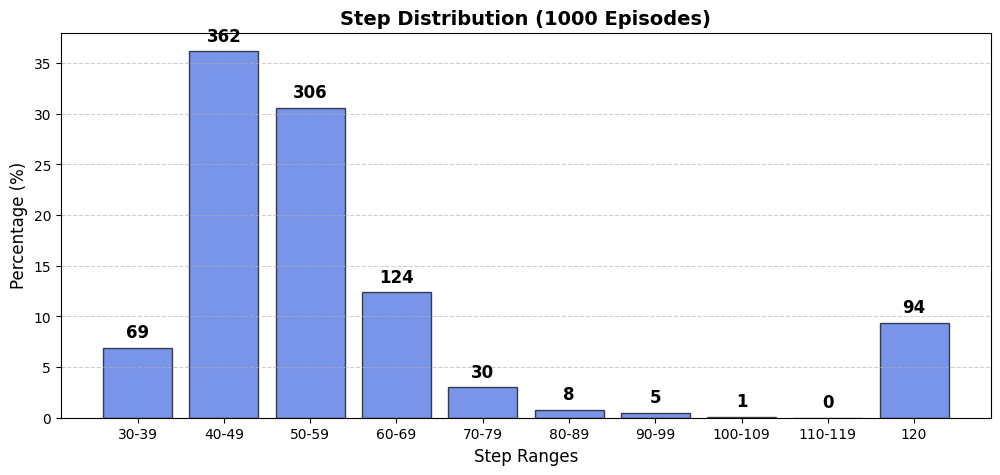

In [ ]:
# Plot graph.
plot_step_distribution(double_steps, num_of_runs)

<br>
<h1>Dueling DDQN - Plot Distribution </h1>
<br>

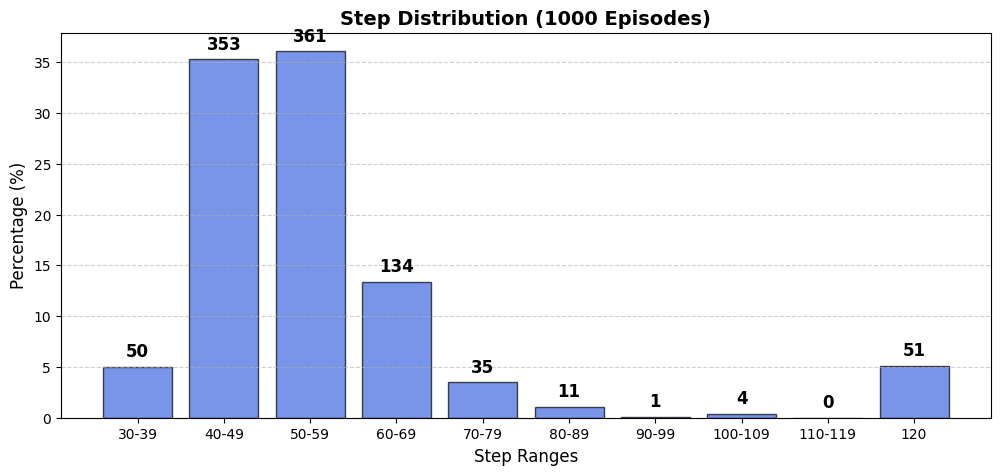

In [ ]:
plot_step_distribution(dueling_steps, num_of_runs)

<br>
<h1>PPO - Plot Distribution </h1>
<br>

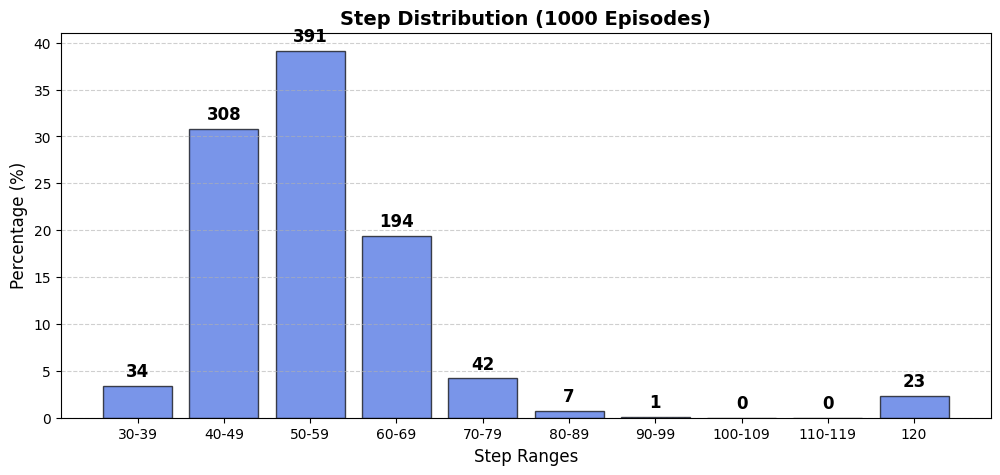

In [ ]:
plot_step_distribution(ppo_steps, num_of_runs)

In [ ]:
# Create Videos
create_video_DQN(DoubleAgent, "double_video")
create_video_DQN(DuelingAgent, "dueling_video")
create_video_PPO(agentPPO, "ppo_video")

([], [])

<br>
<h1>Double DQN - Video </h1>
<br>

In [ ]:
embed_mp4("double_video.mp4")


<br>
<h1>Dueling DDQN - Video </h1>
<br>

In [ ]:
embed_mp4("dueling_video.mp4")

<br>
<h1>PPO - Video </h1>
<br>

In [ ]:
embed_mp4("ppo_video.mp4")